# 📥 Importing needed libraries

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.models import load_model

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/TS/TSC'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('/content/gdrive/MyDrive/TS/TSC'))

# Any results we write to the current directory are saved as output


/content/gdrive/MyDrive/TS/TSC/data0.pickle
/content/gdrive/MyDrive/TS/TSC/data1.pickle
/content/gdrive/MyDrive/TS/TSC/data2.pickle
/content/gdrive/MyDrive/TS/TSC/data5.pickle
/content/gdrive/MyDrive/TS/TSC/data6.pickle
/content/gdrive/MyDrive/TS/TSC/data7.pickle
/content/gdrive/MyDrive/TS/TSC/data8.pickle
/content/gdrive/MyDrive/TS/TSC/std_rgb.pickle
/content/gdrive/MyDrive/TS/TSC/mean_image_gray.pickle
/content/gdrive/MyDrive/TS/TSC/std_gray.pickle
/content/gdrive/MyDrive/TS/TSC/test.pickle
/content/gdrive/MyDrive/TS/TSC/label_names.csv
/content/gdrive/MyDrive/TS/TSC/mean_image_rgb.pickle
/content/gdrive/MyDrive/TS/TSC/datasets_preparing.py
/content/gdrive/MyDrive/TS/TSC/labels.pickle
/content/gdrive/MyDrive/TS/TSC/train.pickle
/content/gdrive/MyDrive/TS/TSC/valid.pickle
['data0.pickle', 'data1.pickle', 'data2.pickle', 'data5.pickle', 'data6.pickle', 'data7.pickle', 'data8.pickle', 'std_rgb.pickle', 'mean_image_gray.pickle', 'std_gray.pickle', 'test.pickle', 'label_names.csv', 'mean_

# 📂 Loading dataset data2.pickle with RGB examples

In [3]:
# Opening file for reading in binary mode
with open('/content/gdrive/MyDrive/TS/TSC/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43


y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


(81, 32, 32, 3)


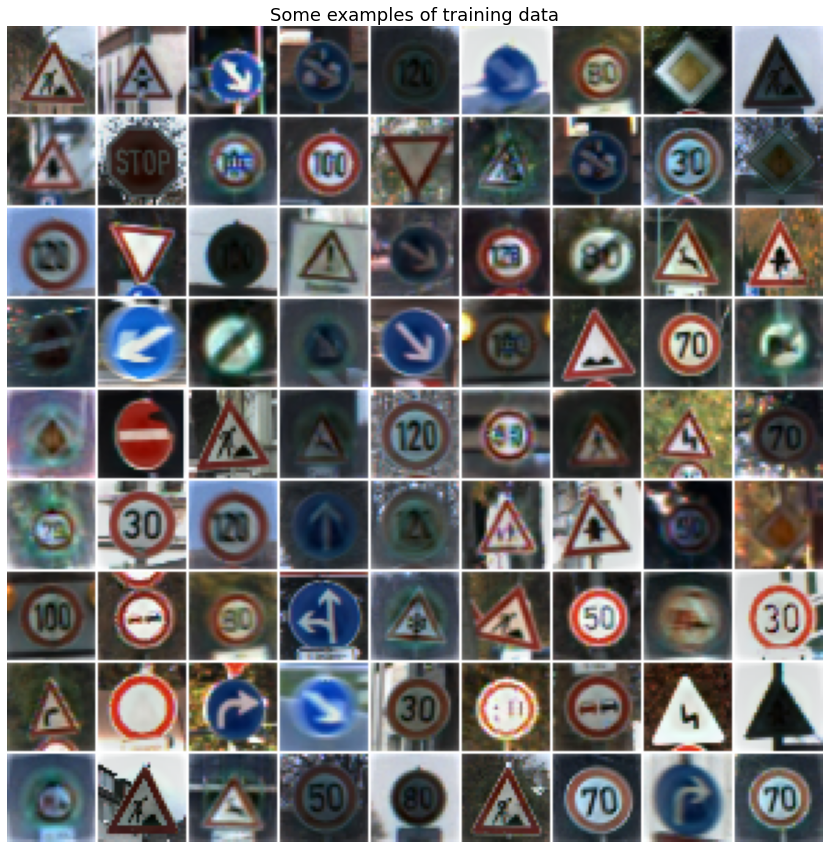

[25 11 38 38  8 38  5 12 25 11 14  7  7 13 25 38  1 12  8 13  7 18 38  8
  6 31 11 17 39 32 38 38  7 22  4 42 12 17 25 31  8  5 27 21  4  4  1  8
 35  8 28 11  2 12  7  9  5 37 30 25  2 10  1 20 15 33 38  1  2  9 21 11
 10 25 31  2  5 25  4 33  4]


In [4]:
%matplotlib inline

# Preparing function for ploting set of examples
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_test'][:81, :, :, :]
testex = data['y_test'][:81]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

# Saving the plot
fig.savefig('training_examples.png')
plt.close()
print(testex)

In [5]:
labels = pd.read_csv('/content/gdrive/MyDrive/TS/TSC/label_names.csv')

# Check point
# Showing first 5 rows from the dataFrame
print(labels)
print()


    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vehicles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

## Building model of CNN 
## Filters of size 3x3

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(32,32, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(43, activation='sigmoid'))
model.add(Flatten())


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='sigmoid'))
model.add(Flatten())
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 512)               2

In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x + epochs))
epochs = 20

h = model.fit(data['x_train'], data['y_train'],
              batch_size=25, epochs = epochs,
              validation_data = (data['x_validation'], data['y_validation']),
              callbacks=[annealer], verbose=1)


Epoch 1/20
3480/3480 [==============================] - 31s 6ms/step - loss: 0.0511 - accuracy: 0.6118 - val_loss: 0.0158 - val_accuracy: 0.8823 - lr: 3.5849e-04
Epoch 2/20
3480/3480 [==============================] - 21s 6ms/step - loss: 0.0064 - accuracy: 0.9645 - val_loss: 0.0104 - val_accuracy: 0.9388 - lr: 3.4056e-04
Epoch 3/20
3480/3480 [==============================] - 19s 6ms/step - loss: 0.0028 - accuracy: 0.9849 - val_loss: 0.0113 - val_accuracy: 0.9238 - lr: 3.2353e-04
Epoch 4/20
3480/3480 [==============================] - 21s 6ms/step - loss: 0.0016 - accuracy: 0.9914 - val_loss: 0.0128 - val_accuracy: 0.9215 - lr: 3.0736e-04
Epoch 5/20
3480/3480 [==============================] - 19s 6ms/step - loss: 0.0011 - accuracy: 0.9944 - val_loss: 0.0140 - val_accuracy: 0.9283 - lr: 2.9199e-04
Epoch 6/20
3480/3480 [==============================] - 20s 6ms/step - loss: 8.1186e-04 - accuracy: 0.9960 - val_loss: 0.0142 - val_accuracy: 0.9259 - lr: 2.7739e-04
Epoch 7/20
3480/3480 [==

In [9]:
print('Epochs={0:d}, training accuracy={1:.5f}, validation accuracy={2:.5f}'.\
      format(epochs, max(h.history['accuracy']), max(h.history['val_accuracy'])))


Epochs=20, training accuracy=0.99966, validation accuracy=0.94875


In [ ]:
model = load_model('/content/gdrive/MyDrive/TS/model-3x3.h5')

## Calculating accuracy with testing dataset

In [10]:
temp = model.predict(data['x_test'])
temp = np.argmax(temp, axis=1)
# We compare predicted class with correct class for all input images
# And calculating mean value among all values of following numpy array
# By saying 'testing_accuracy == data['y_test']' we create numpy array with True and False values
# 'np.mean' function will return average of the array elements
# The average is taken over the flattened array by default
temp = np.mean(temp == data['y_test'])
    
print('data2 filter  testing accuracy = {1:.5f}'.format(3, temp))


395/395 [==============================] - 1s 2ms/step
data2 filter  testing accuracy = 0.93666


In [11]:
model.evaluate(data['x_test'], data['y_test'])
# ???????????????

395/395 [==============================] - 3s 6ms/step - loss: 228.7844 - accuracy: 0.0032


[228.78440856933594, 0.003167062532156706]

# Predicting with images from test dataset

(1, 32, 32, 3)
[25]


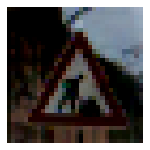

1/1 [==============================] - 0s 78ms/step


(43,)
ClassId: 25
Label: Road work
(1, 32, 32, 3)
[11]


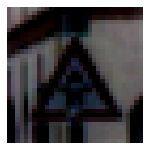

1/1 [==============================] - 0s 29ms/step


(43,)
ClassId: 11
Label: Right-of-way at the next intersection
(1, 32, 32, 3)
[38]


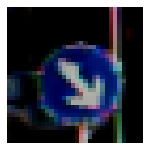

1/1 [==============================] - 0s 32ms/step


(43,)
ClassId: 38
Label: Keep right
(1, 32, 32, 3)
[38]


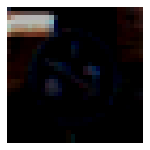

1/1 [==============================] - 0s 26ms/step


(43,)
ClassId: 38
Label: Keep right
(1, 32, 32, 3)
[8]


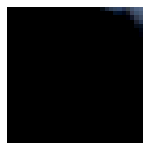

1/1 [==============================] - 0s 30ms/step


(43,)
ClassId: 8
Label: Speed limit (120km/h)
(1, 32, 32, 3)
[38]


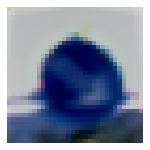

1/1 [==============================] - 0s 29ms/step
(43,)
ClassId: 38
Label: Keep right
(1, 32, 32, 3)
[5]


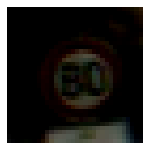

1/1 [==============================] - 0s 29ms/step
(43,)
ClassId: 5
Label: Speed limit (80km/h)
(1, 32, 32, 3)
[12]


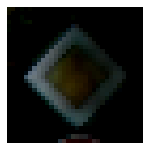

1/1 [==============================] - 0s 32ms/step


(43,)
ClassId: 12
Label: Priority road
(1, 32, 32, 3)
[25]


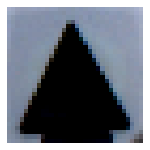

1/1 [==============================] - 0s 27ms/step


(43,)
ClassId: 25
Label: Road work
(1, 32, 32, 3)
[11]


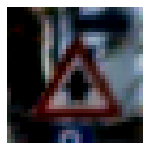

1/1 [==============================] - 0s 27ms/step
(43,)
ClassId: 11
Label: Right-of-way at the next intersection


In [12]:
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []
    
    # Reading 'csv' file and getting image's labels
    r = pd.read_csv(file)
    # Going through all names
    for name in r['SignName']:
        # Adding from every row second column with name of the label
        label_list.append(name)
    
    # Returning resulted list with labels
    return label_list
for i in range(10):
  x_input = data['x_test'][i:i+1]
  print(x_input.shape)
  y_input = data['y_test'][i:i+1]
  print(y_input)
  plt.rcParams['figure.figsize'] = (2.5, 2.5) # Setting default size of plots
  plt.imshow(x_input[0, :, :, :])
  plt.axis('off')

  # Showing the plot
  plt.show()
  scores = model.predict(x_input)
  print(scores[0].shape) # (43,)

# Scores is given for image with 43 numbers of predictions for each class
# Getting only one class with maximum value
  prediction = np.argmax(scores)
  print('ClassId:', prediction)
  labels = label_text('/content/gdrive/MyDrive/TS/TSC/label_names.csv')

# Printing label for classified Traffic Sign
  print('Label:', labels[prediction])

# 💾 Saving models

In [ ]:
model.save('/content/gdrive/MyDrive/TS/model-3x3.h5')

# # Saving model locally without committing
# from IPython.display import FileLink

# FileLink('model-3x3.h5')
